In [ ]:
%matplotlib inline  
from fastai.vision import *
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from efficientnet_pytorch import EfficientNet

In [ ]:
def strt_split(x, y, n_folds=10, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)


def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float, SUFFIX = 'PHASE_1_COS'):
    n = len(learn.data.train_dl)
    anneal_start = int(n*n_epochs*start_pct)
    anneal_end = int(n*n_epochs) - anneal_start
    phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
             TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.callbacks.append(SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}'))
    learn.fit(n_epochs)

In [ ]:
PATH = Path('..')
BS =            512
SZ =            224
FOLD =0
EXP_NAME =      f'NB_EXP_110_CV_{FOLD}_{SZ}'
IMG_TRAIN_224 = PATH/'train_images__3chn_bg_224'
IMG_TEST_224  = PATH/'test_images__3chn_bg_224'
DF_TRAIN =      pd.read_csv(PATH/'train_labels_as_strings.csv')
DF_SUBMI =      pd.read_csv(PATH/'stage_1_sample_submission.csv')



DF_SUBMI['fn'] = DF_SUBMI.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.png')
DF_TRAIN['labels'].fillna('', inplace=True)
VAL_IDX = strt_split(DF_TRAIN['fn'], DF_TRAIN['labels'])[FOLD]

In [ ]:
ItemList.label_from_df = modified_label_from_df
test_fns = DF_SUBMI.fn.unique()
tfms = get_transforms(max_rotate=245,
                      flip_vert=True,
                      max_zoom=1.4, 
                      max_lighting=0.3)

data = (ImageList.from_csv('..', 'train_labels_as_strings.csv', folder=IMG_TRAIN_224.name)
        .split_by_idxs(valid_idx=VAL_IDX[0], train_idx=VAL_IDX[1])
        .label_from_df(label_delim=' ')
        .transform(tfms = tfms,size=SZ)
        .add_test('../' +IMG_TEST_224.name + '/' + test_fns)
        .databunch(bs=BS)
        .normalize(imagenet_stats))

        

In [ ]:
data.show_batch()

In [ ]:
md_ef =EfficientNet.from_pretrained('efficientnet-b0', num_classes=data.c)

In [7]:

learn = Learner(data,
                md_ef,
                wd=1e-2,
                bn_wd=False, 
                true_wd=True, 
                metrics=[accuracy_thresh])
weights = [2, 1, 1, 1, 1, 1]
learn.loss_func  = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor(weights).cuda())
learn.model = nn.DataParallel(learn.model)
learn.to_fp16()
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


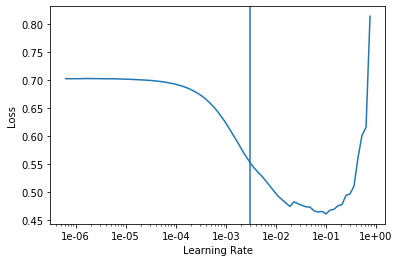

In [8]:
lr = 0.003
learn.recorder.plot()
plt.axvline(lr)

In [9]:
learn.unfreeze()
SUFFIX = 'UNFRZ'
learn.fit_one_cycle(50,
                    lr, 
                    pct_start=0.2,
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}')])

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.099507,0.088107,0.968523,20:41
1,0.090088,0.080247,0.971561,20:27
2,0.086266,0.087446,0.970747,20:38
3,0.084057,0.075961,0.973335,20:35
4,0.083053,0.087009,0.970218,20:26
5,0.082670,0.076837,0.972872,20:32
6,0.079859,0.075615,0.972806,20:29
7,0.080745,0.076902,0.973332,20:26
8,0.078780,0.074858,0.973550,20:29
9,0.077918,0.072561,0.974261,20:33


Better model found at epoch 0 with valid_loss value: 0.08810697495937347.
Better model found at epoch 1 with valid_loss value: 0.08024726063013077.
Better model found at epoch 3 with valid_loss value: 0.0759613886475563.
Better model found at epoch 6 with valid_loss value: 0.07561516761779785.
Better model found at epoch 8 with valid_loss value: 0.07485807687044144.
Better model found at epoch 9 with valid_loss value: 0.07256060838699341.
Better model found at epoch 10 with valid_loss value: 0.07111842930316925.
Better model found at epoch 14 with valid_loss value: 0.06920864433050156.
Better model found at epoch 16 with valid_loss value: 0.06589207053184509.
Better model found at epoch 18 with valid_loss value: 0.06500200182199478.
Better model found at epoch 19 with valid_loss value: 0.06439331918954849.
Better model found at epoch 21 with valid_loss value: 0.06315859407186508.
Better model found at epoch 24 with valid_loss value: 0.061161287128925323.
Better model found at epoch 25 

In [10]:
def get_preds(learn:Learner, sub_fn: str=f'{EXP_NAME}_PHASE_2_COS', TTA: bool = False, dt_type = DatasetType.Test):
    if TTA:
        learn.to_fp32()
        preds, targs = learn.TTA(ds_type=dt_type)
        sub_fn = f'{sub_fn}_TTA'
    else:
        preds, targs = learn.get_preds(dt_type)
    ids = []
    labels = []

    for fn, pred in zip(test_fns, preds):
        for i, label in enumerate(data.train_ds.classes):
            ids.append(f"{fn.split('.')[0]}_{label}")
            predicted_probability = '{0:1.10f}'.format(pred[i].item())
            labels.append(predicted_probability)
    pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(f'{sub_fn}.csv', index=False)

In [11]:
get_preds(learn)

In [12]:
get_preds(learn, TTA=True)

In [13]:
!sudo shutdown

Shutdown scheduled for Mon 2019-10-07 12:01:13 UTC, use 'shutdown -c' to cancel.
